# EDA and Preprocessing for CFPB Complaint Data

This notebook covers exploratory data analysis (EDA) and preprocessing for the CFPB complaint dataset, as required for the RAG pipeline.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pathlib import Path

# Set plotting style
sns.set(style="whitegrid")

# Load dataset
DATA_PATH = Path('../data/raw/complaints.csv').resolve()
df = pd.read_csv(DATA_PATH, low_memory=False)
print(f'Dataset shape: {df.shape}')
    

Dataset shape: (9609797, 18)


## Initial Data Overview

In [3]:
df.info()
df.head()
df.columns.tolist()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9609797 entries, 0 to 9609796
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memory usage: 1.3+

['Date received',
 'Product',
 'Sub-product',
 'Issue',
 'Sub-issue',
 'Consumer complaint narrative',
 'Company public response',
 'Company',
 'State',
 'ZIP code',
 'Tags',
 'Consumer consent provided?',
 'Submitted via',
 'Date sent to company',
 'Company response to consumer',
 'Timely response?',
 'Consumer disputed?',
 'Complaint ID']

## Distribution of Complaints by Product

C:\Users\Eyoel\AppData\Local\Temp\ipykernel_25408\2844524723.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=product_counts.index, y=product_counts.values, palette="viridis")


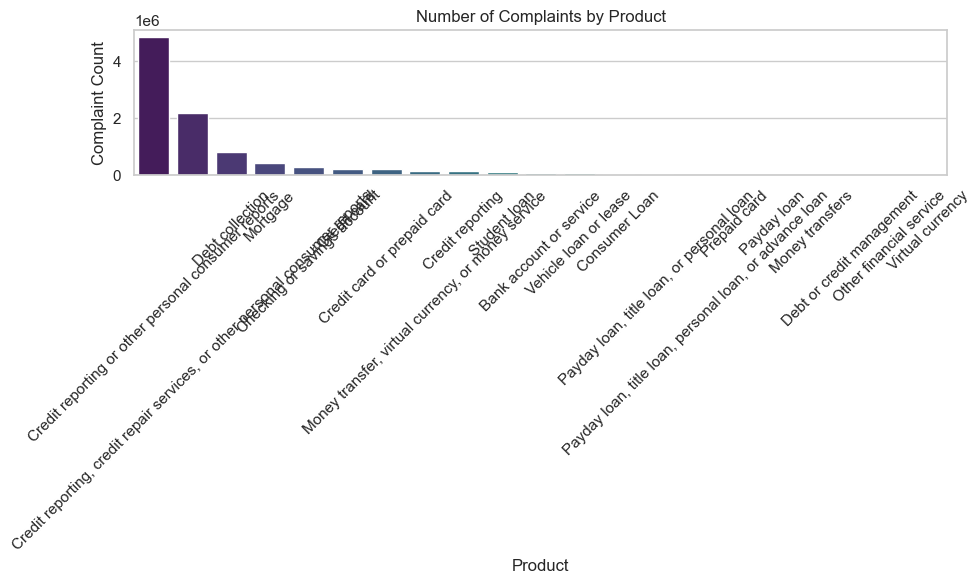

Product
Credit reporting or other personal consumer reports                             4834855
Credit reporting, credit repair services, or other personal consumer reports    2163857
Debt collection                                                                  799197
Mortgage                                                                         422254
Checking or savings account                                                      291178
Credit card                                                                      226686
Credit card or prepaid card                                                      206369
Money transfer, virtual currency, or money service                               145066
Credit reporting                                                                 140429
Student loan                                                                     109717
Bank account or service                                                           86205
Vehicle loan or lease   

In [4]:
product_counts = df['Product'].value_counts()
plt.figure(figsize=(10,6))
sns.barplot(x=product_counts.index, y=product_counts.values, palette="viridis")
plt.title('Number of Complaints by Product')
plt.ylabel('Complaint Count')
plt.xlabel('Product')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
product_counts

## Narrative Length Analysis

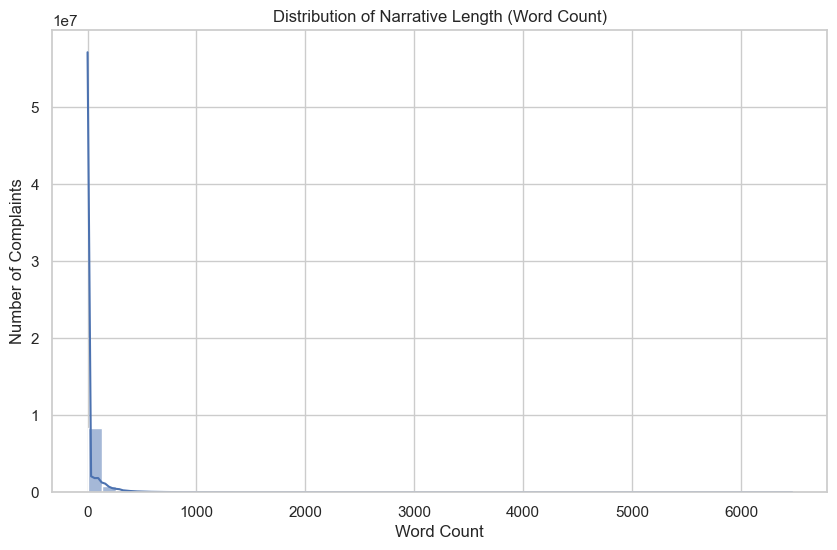

Shortest narrative: 0
Longest narrative: 6469


In [5]:
df['narrative_length'] = df['Consumer complaint narrative'].fillna('').apply(lambda x: len(x.split()))
plt.figure(figsize=(10,6))
sns.histplot(df['narrative_length'], bins=50, kde=True)
plt.title('Distribution of Narrative Length (Word Count)')
plt.xlabel('Word Count')
plt.ylabel('Number of Complaints')
plt.show()
print('Shortest narrative:', df['narrative_length'].min())
print('Longest narrative:', df['narrative_length'].max())

## Complaints With and Without Narratives

In [6]:
with_narrative = df['Consumer complaint narrative'].notna().sum()
without_narrative = df['Consumer complaint narrative'].isna().sum()
print(f'Complaints with narrative: {with_narrative}')
print(f'Complaints without narrative: {without_narrative}')

Complaints with narrative: 2980756
Complaints without narrative: 6629041


## Data Filtering and Cleaning

In [7]:
products_of_interest = ["Credit card", "Personal loan", "Buy Now, Pay Later (BNPL)", "Savings account", "Money transfers"]
filtered = df[df['Product'].isin(products_of_interest)]
filtered = filtered[filtered['Consumer complaint narrative'].notna() & (filtered['Consumer complaint narrative'].str.strip() != '')]

In [8]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'(i am writing to file a complaint|i am writing to complain|this complaint is about)', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

filtered['cleaned_narrative'] = filtered['Consumer complaint narrative'].apply(clean_text)
filtered = filtered[filtered['cleaned_narrative'].str.strip() != '']
filtered.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,narrative_length,cleaned_narrative
12237,2025-06-13,Credit card,Store credit card,Getting a credit card,Card opened without my consent or knowledge,A XXXX XXXX card was opened under my name by a...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",TX,78230,Servicemember,Consent provided,Web,2025-06-13,Closed with non-monetary relief,Yes,NaN,14069121,91,a xxxx xxxx card was opened under my name by a...
13280,2025-06-12,Credit card,General-purpose credit card or charge card,"Other features, terms, or problems",Other problem,"Dear CFPB, I have a secured credit card with c...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",NY,11220,NaN,Consent provided,Web,2025-06-13,Closed with monetary relief,Yes,NaN,14047085,156,dear cfpb i have a secured credit card with ci...
13506,2025-06-12,Credit card,General-purpose credit card or charge card,Incorrect information on your report,Account information incorrect,I have a Citi rewards cards. The credit balanc...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",IL,60067,NaN,Consent provided,Web,2025-06-12,Closed with explanation,Yes,NaN,14040217,233,i have a citi rewards cards the credit balance...
13955,2025-06-09,Credit card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,b'I am writing to dispute the following charge...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",TX,78413,Older American,Consent provided,Web,2025-06-09,Closed with monetary relief,Yes,NaN,13968411,454,b i am writing to dispute the following charge...
14249,2025-06-09,Credit card,General-purpose credit card or charge card,Problem when making payments,Problem during payment process,"Although the account had been deemed closed, I...",Company believes it acted appropriately as aut...,Atlanticus Services Corporation,NY,11212,Older American,Consent provided,Web,2025-06-09,Closed with monetary relief,Yes,NaN,13965746,170,although the account had been deemed closed i ...


In [9]:
# Save cleaned data
filtered.to_csv('../data/processed/filtered_complaints.csv', index=False)
print('Filtered dataset saved to data/filtered_complaints.csv')

Filtered dataset saved to data/filtered_complaints.csv


## Key Findings from EDA

- The dataset contains complaints across multiple products, with the top five products selected for further analysis.
- Narrative lengths vary widely, with some complaints being very short and others much longer.
- A significant portion of complaints do not have narratives and were excluded from further processing.
- The text cleaning process removed boilerplate and standardized the narratives for downstream tasks.